In [52]:
import matplotlib.pyplot as plt

import json
import sys
from pathlib import Path

sys.path.append("..")

from collections import Counter
from pathlib import Path
from typing import List

from scrapers.utils import (
    convert_weakness, 
    epoch_to_year,
    map_severity_to_level,
    SeverityLevel, 
)

def load_reports(directory_path: str) -> List[dict]:
    """
    Load all JSON reports from the specified directory.
    
    Args:
        directory_path (str): Path to the directory containing JSON reports
        
    Returns:
        List[dict]: List of loaded JSON report objects
    """
    reports = []
    reports_dir = Path(directory_path)
    
    for report_file in reports_dir.glob("*.json"):
        try:
            with open(report_file, "r") as f:
                report = json.load(f)
                reports.append(report)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error loading {report_file}: {e}")
    
    return reports

def filter_no_code_reports(reports: List[dict]) -> List[dict]:
    """
    Filter reports to include only those that don't require code, CVEs, or are CTF challenges.
    
    Args:
        reports (List[dict]): List of report objects
        
    Returns:
        List[dict]: Filtered list of reports
    """
    # Initialize counters
    total_count = len(reports)
    requires_code_count = 0
    requires_cve_count = 0
    is_ctf_count = 0
    messed_up_reports = 0
    
    # Filter reports
    filtered_reports = []
    
    for report in reports:
        # Check exclusion criteria
        if report.get("requires_code", False):
            requires_code_count += 1
            continue
        if report.get("requires_CVE", False):
            requires_cve_count += 1
            continue
        if report.get("is_ctf", False):
            is_ctf_count += 1
            continue
        if report.get("severity") == "[":
            messed_up_reports += 1
            continue
        
        # If it passes all filters, add to filtered list
        filtered_reports.append(report)
    
    # Calculate filtered count
    filtered_count = len(filtered_reports)
    
    # Print statistics
    print(f"Total reports: {total_count}")
    print(f"Filtered reports: {filtered_count}")
    print(f"Excluded reports:")
    print(f"  - Requires code: {requires_code_count}")
    print(f"  - Requires CVE: {requires_cve_count}")
    print(f"  - Is CTF challenge: {is_ctf_count}")
    print(f"  - Messed up reports: {messed_up_reports}")
    
    return filtered_reports

reports = load_reports("high_reports")
filtered_reports = filter_no_code_reports(reports)

Error loading high_reports\1618100.json: Expecting value: line 1 column 1 (char 0)
Error loading high_reports\183239.json: Expecting value: line 1 column 1 (char 0)
Error loading high_reports\186194.json: Expecting value: line 1 column 1 (char 0)
Error loading high_reports\192321.json: Expecting value: line 1 column 1 (char 0)
Error loading high_reports\217745.json: Expecting value: line 1 column 1 (char 0)
Error loading high_reports\312118.json: Expecting value: line 1 column 1 (char 0)
Error loading high_reports\744692.json: Expecting value: line 1 column 1 (char 0)
Total reports: 1822
Filtered reports: 1088
Excluded reports:
  - Requires code: 573
  - Requires CVE: 128
  - Is CTF challenge: 2
  - Messed up reports: 31


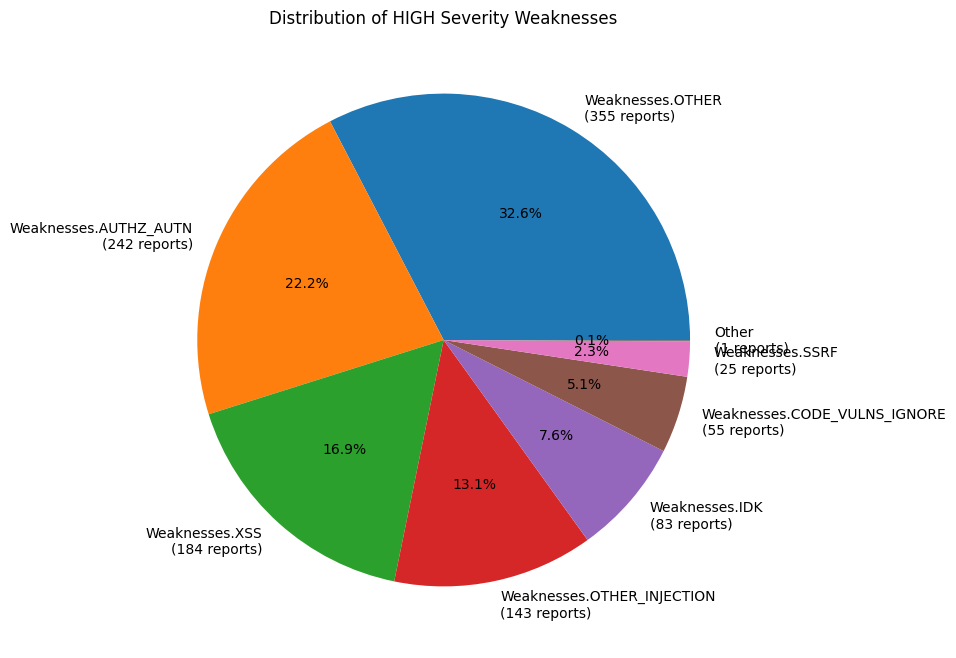

In [4]:
def analyze_top_weaknesses(reports):
    """Analyze top 7 weaknesses across all years (HIGH severity only)
    
    Args:
        reports (List[dict]): List of report objects
    """
    # Initialize weakness counter
    weakness_counts = Counter()
    
    # Process all reports
    for report in reports:
        try:
            severity = map_severity_to_level(report.get("severity"))
            if severity != SeverityLevel.HIGH.value:
                continue
                
            weaknesses = report.get("weaknesses", [])
            if not weaknesses:
                continue
                
            # Count each weakness
            for weakness in weaknesses:
                weakness = convert_weakness(weakness)
                weakness_counts[weakness] += 1
                
        except (KeyError):
            continue
            
    # Get top 7 weaknesses
    top_7 = weakness_counts.most_common(7)
    
    # Calculate sum of other weaknesses
    top_7_names = [w[0] for w in top_7]
    other_sum = sum(count for weakness, count in weakness_counts.items() 
                   if weakness not in top_7_names)
    
    # Prepare data for pie chart
    labels = [f"{weakness}\n({count} reports)" for weakness, count in top_7]
    labels.append(f"Other\n({other_sum} reports)")
    
    sizes = [count for _, count in top_7]
    sizes.append(other_sum)
    
    # Create pie chart
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.pie(sizes, labels=labels, autopct="%1.1f%%")
    ax.set_title("Distribution of HIGH Severity Weaknesses")
    
    plt.show()

# Run the analysis
analyze_top_weaknesses(filtered_reports)



Year 2019:
#1: Weaknesses.OTHER (55 reports)
#2: Weaknesses.AUTHZ_AUTN (26 reports)
#3: Weaknesses.OTHER_INJECTION (24 reports)
#4: Weaknesses.XSS (24 reports)
#5: Weaknesses.IDK (6 reports)

Year 2020:
#1: Weaknesses.OTHER (60 reports)
#2: Weaknesses.AUTHZ_AUTN (49 reports)
#3: Weaknesses.XSS (26 reports)
#4: Weaknesses.OTHER_INJECTION (23 reports)
#5: Weaknesses.CODE_VULNS_IGNORE (17 reports)

Year 2021:
#1: Weaknesses.OTHER (65 reports)
#2: Weaknesses.AUTHZ_AUTN (47 reports)
#3: Weaknesses.OTHER_INJECTION (25 reports)
#4: Weaknesses.XSS (20 reports)
#5: Weaknesses.CODE_VULNS_IGNORE (11 reports)

Year 2022:
#1: Weaknesses.OTHER (53 reports)
#2: Weaknesses.AUTHZ_AUTN (32 reports)
#3: Weaknesses.XSS (20 reports)
#4: Weaknesses.IDK (17 reports)
#5: Weaknesses.OTHER_INJECTION (16 reports)

Year 2023:
#1: Weaknesses.OTHER (23 reports)
#2: Weaknesses.AUTHZ_AUTN (21 reports)
#3: Weaknesses.OTHER_INJECTION (17 reports)
#4: Weaknesses.XSS (14 reports)
#5: Weaknesses.IDK (4 reports)

Year 202

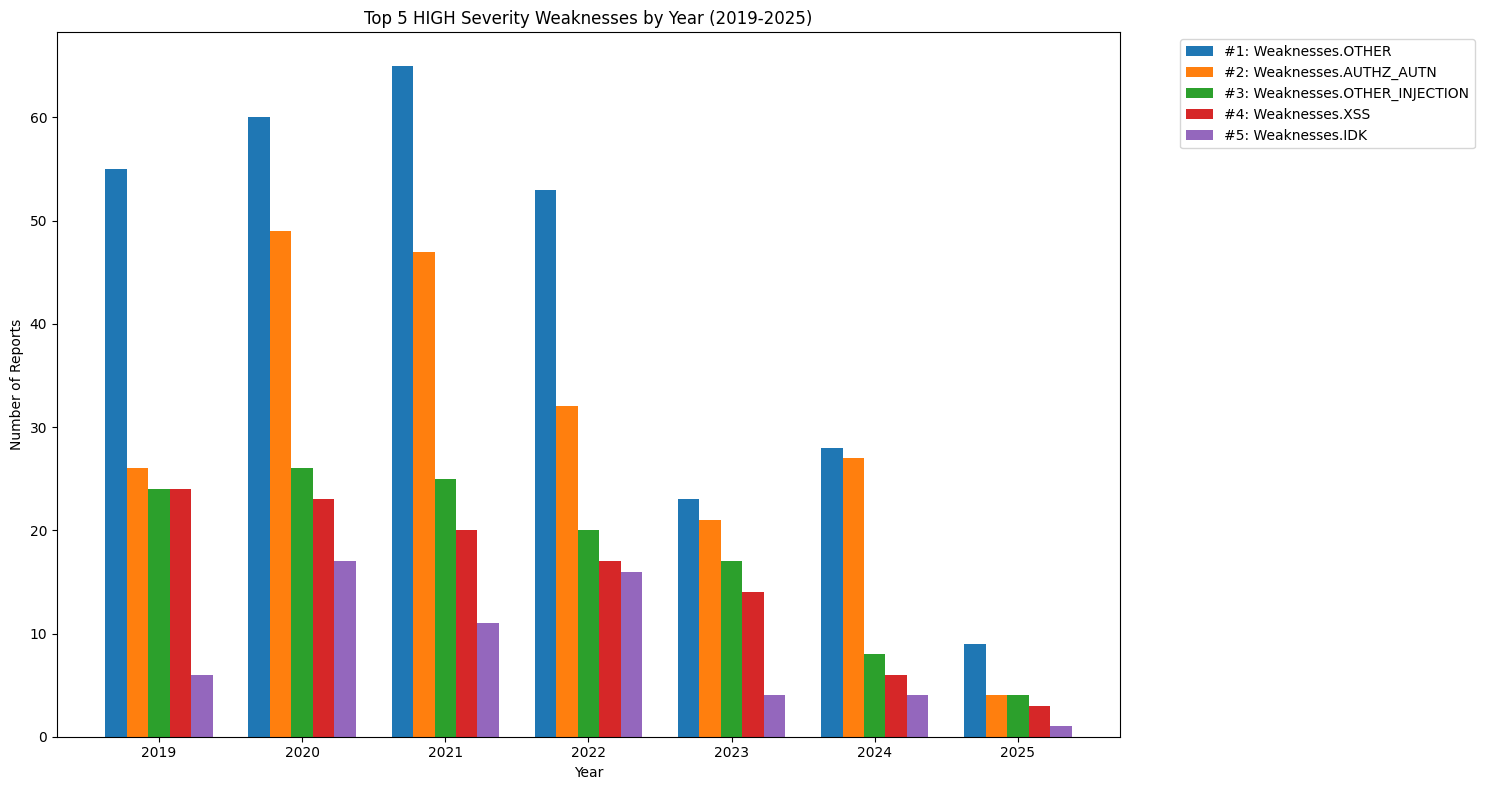

In [5]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

def analyze_top_weaknesses_by_year(reports):
    """Analyze top 5 weaknesses for each year from 2019-2025 (HIGH severity only)
    
    Args:
        reports: List of report JSON objects
    """
    # Initialize yearly weakness counters
    yearly_weaknesses = {year: Counter() for year in range(2019, 2026)}
    
    # Process all reports
    for report in reports:
        try:
            # Skip if not HIGH severity
            severity = map_severity_to_level(report.get("severity"))
            if severity != SeverityLevel.HIGH.value:
                continue
                
            # Get year and weaknesses
            year = epoch_to_year(report["disclosed_date"])
            if year < 2019 or year > 2025:
                continue
                
            weaknesses = report.get("weaknesses", [])
            if not weaknesses:
                continue
                
            # Count each weakness for that year
            for weakness in weaknesses:
                weakness = convert_weakness(weakness)
                yearly_weaknesses[year][weakness] += 1
                
        except (KeyError):
            continue
            
    # Plot results
    fig, ax = plt.subplots(figsize=(15, 8))
    
    x = np.arange(2019, 2026)
    width = 0.15
    offsets = np.linspace(-2*width, 2*width, 5)
    
    for i in range(5):
        yearly_values = []
        weakness_names = []
        
        for year in range(2019, 2026):
            # Get top 5 weaknesses for this year
            top_5 = yearly_weaknesses[year].most_common(5)
            
            # Get ith weakness if available, otherwise 0
            if i < len(top_5):
                weakness_names.append(top_5[i][0])
                yearly_values.append(top_5[i][1])
                if i == 0:  # Only print once per year
                    print(f"\nYear {year}:")
                    for rank, (weakness, count) in enumerate(top_5, 1):
                        print(f"#{rank}: {weakness} ({count} reports)")
            else:
                yearly_values.append(0)
                
        # Plot bar for this weakness position
        if any(yearly_values):  # Only plot if there are non-zero values
            ax.bar(x + offsets[i], yearly_values, width, 
                   label=f"#{i+1}: {weakness_names[0]}")
            
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Reports")
    ax.set_title("Top 5 HIGH Severity Weaknesses by Year (2019-2025)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_xticks(x)
    
    plt.tight_layout() 
    plt.show()

# Run the analysis
analyze_top_weaknesses_by_year(filtered_reports)


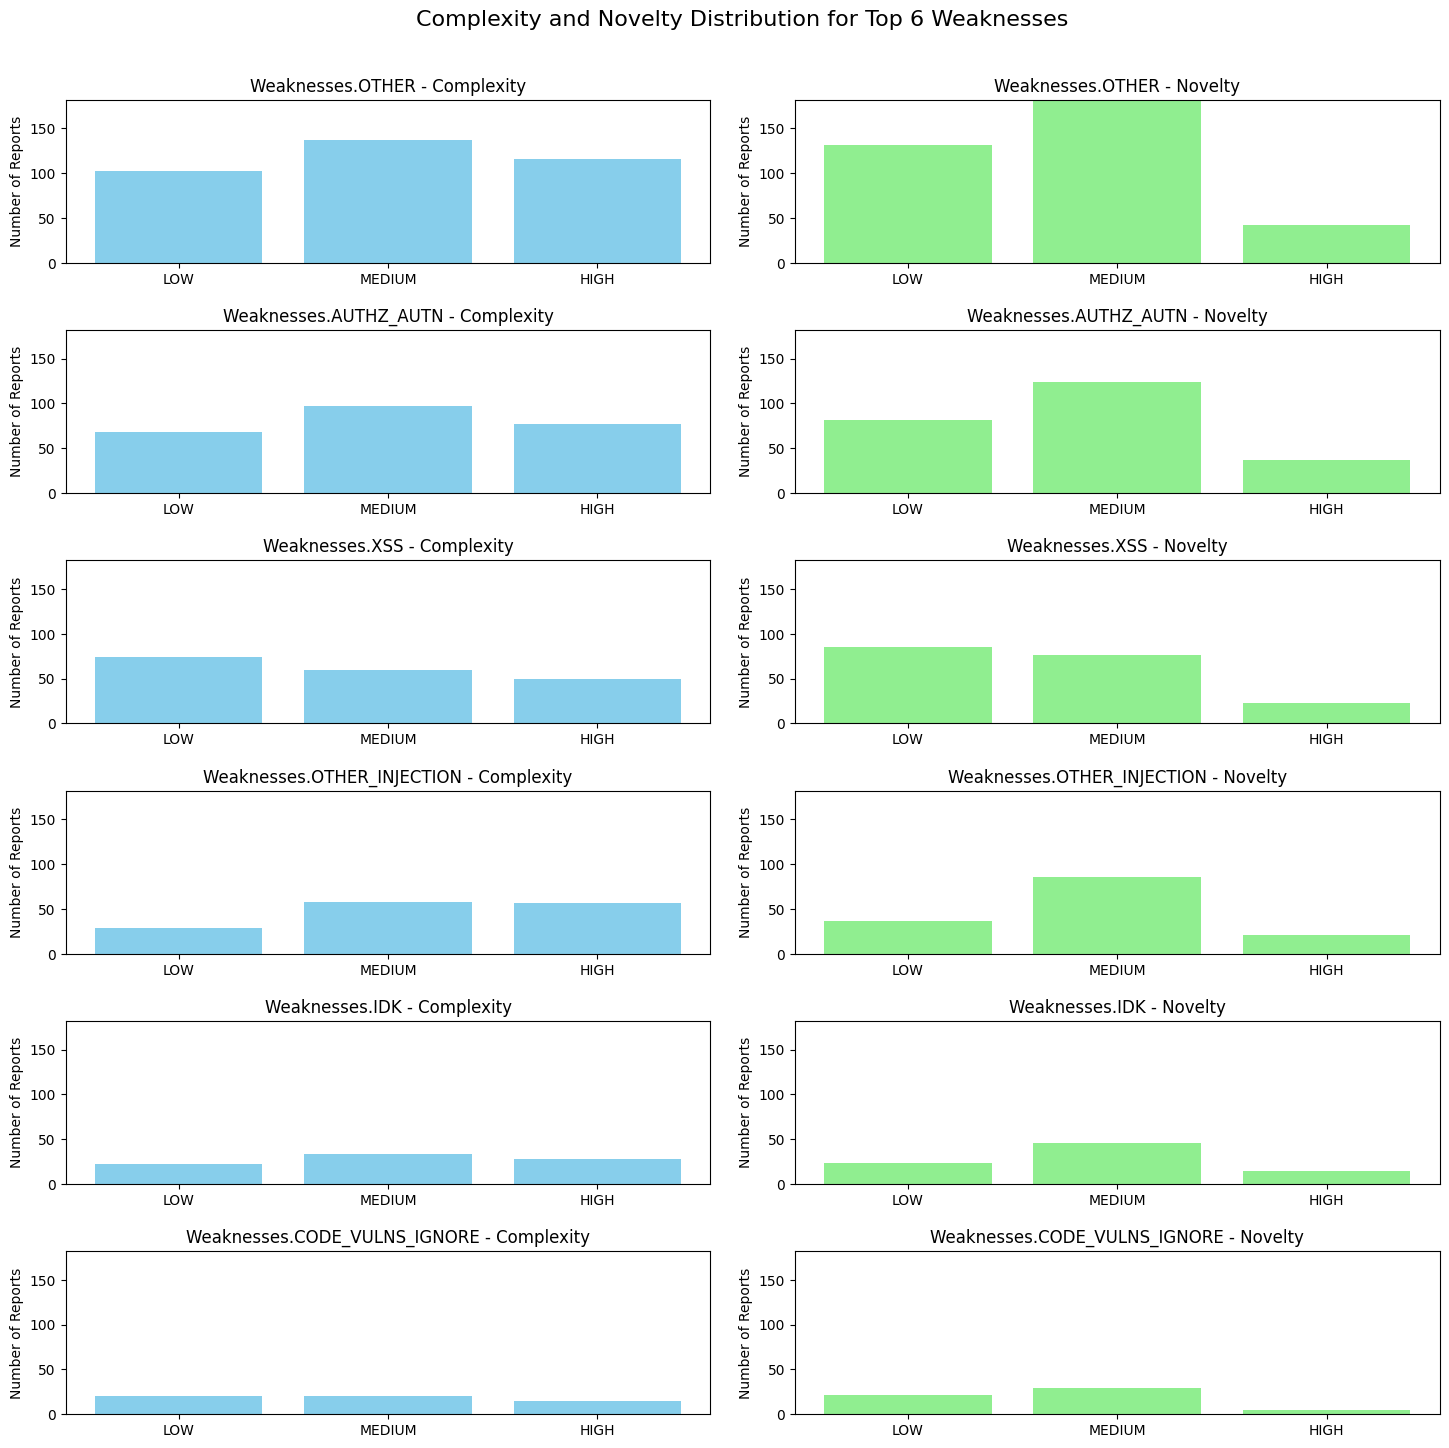

In [6]:
from pathlib import Path
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from typing import Union, List

class SeverityLevel(Enum):
    HIGH = "HIGH"
    MEDIUM = "MEDIUM"
    LOW = "LOW"

def map_severity_to_level(severity: Union[List[float], None]) -> str:
    """Map severity scores to standardized levels
    
    Args:
        severity: List of severity scores or None
    Returns:
        Severity level string
    """
    if not severity:  # Handle None or empty list
        return SeverityLevel.LOW.value
        
    # Filter out None values and convert to float
    valid_scores = [float(score) for score in severity if score is not None]
    
    if not valid_scores:  # If no valid scores after filtering
        return SeverityLevel.LOW.value
    
    # Use the highest severity score
    max_severity = max(valid_scores)
    
    if max_severity >= 7.0:
        return SeverityLevel.HIGH.value
    elif max_severity >= 4.0:
        return SeverityLevel.MEDIUM.value
    else:
        return SeverityLevel.LOW.value

def analyze_weakness_complexity_novelty(reports):
    """Analyze complexity and novelty for top 6 weaknesses
    
    Args:
        reports: List of report JSON objects
    """
    # Initialize weakness counter
    weakness_counts = Counter()
    weakness_data = {}
    
    # Process all reports
    for report in reports:
        try:
            # Skip if not HIGH severity
            severity = map_severity_to_level(report.get("severity"))
            if severity != SeverityLevel.HIGH.value:
                continue
            
            complexity = report.get("complexity")
            novelty = report.get("novelty")
            
            weaknesses = report.get("weaknesses", [])
            if not weaknesses:
                continue
            
            # Count each weakness and collect complexity/novelty data
            for weakness in weaknesses:
                weakness = convert_weakness(weakness)
                weakness_counts[weakness] += 1
                
                if weakness not in weakness_data:
                    weakness_data[weakness] = {"complexity": [], "novelty": []}
                
                if complexity:
                    weakness_data[weakness]["complexity"].append(complexity)
                if novelty:
                    weakness_data[weakness]["novelty"].append(novelty)
                
        except (KeyError):
            continue
    
    # Get top 6 weaknesses
    top_6 = [w for w, _ in weakness_counts.most_common(6)]
    
    # Create a figure with 6 rows and 2 columns
    fig, axes = plt.subplots(6, 2, figsize=(15, 15))
    fig.tight_layout(pad=3.0)
    
    # Define categories for complexity and novelty
    complexity_categories = ["LOW", "MEDIUM", "HIGH"]
    novelty_categories = ["LOW", "MEDIUM", "HIGH"]
    
    # Find the maximum count across all histograms to set a consistent y-axis
    max_count = 0
    for weakness in top_6:
        if weakness in weakness_data:
            complexity_data = weakness_data[weakness]["complexity"]
            novelty_data = weakness_data[weakness]["novelty"]
            
            complexity_counts = Counter(complexity_data)
            novelty_counts = Counter(novelty_data)
            
            max_count = max(max_count, 
                           max([complexity_counts.get(cat, 0) for cat in complexity_categories], default=0),
                           max([novelty_counts.get(cat, 0) for cat in novelty_categories], default=0))
    
    # Plot histograms for each weakness
    for i, weakness in enumerate(top_6):
        if weakness in weakness_data:
            # Complexity histogram
            complexity_data = weakness_data[weakness]["complexity"]
            complexity_counts = Counter(complexity_data)
            
            # Convert to arrays for plotting
            complexity_values = [complexity_counts.get(cat, 0) for cat in complexity_categories]
            
            axes[i, 0].bar(complexity_categories, complexity_values, color="skyblue")
            axes[i, 0].set_title(f"{weakness} - Complexity")
            axes[i, 0].set_ylabel("Number of Reports")
            axes[i, 0].set_ylim(0, max_count)  # Set consistent y-axis limit
            
            # Novelty histogram
            novelty_data = weakness_data[weakness]["novelty"]
            novelty_counts = Counter(novelty_data)
            
            # Convert to arrays for plotting
            novelty_values = [novelty_counts.get(cat, 0) for cat in novelty_categories]
            
            axes[i, 1].bar(novelty_categories, novelty_values, color="lightgreen")
            axes[i, 1].set_title(f"{weakness} - Novelty")
            axes[i, 1].set_ylabel("Number of Reports")
            axes[i, 1].set_ylim(0, max_count)  # Set consistent y-axis limit
    
    plt.suptitle("Complexity and Novelty Distribution for Top 6 Weaknesses", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Run the analysis
analyze_weakness_complexity_novelty(filtered_reports)


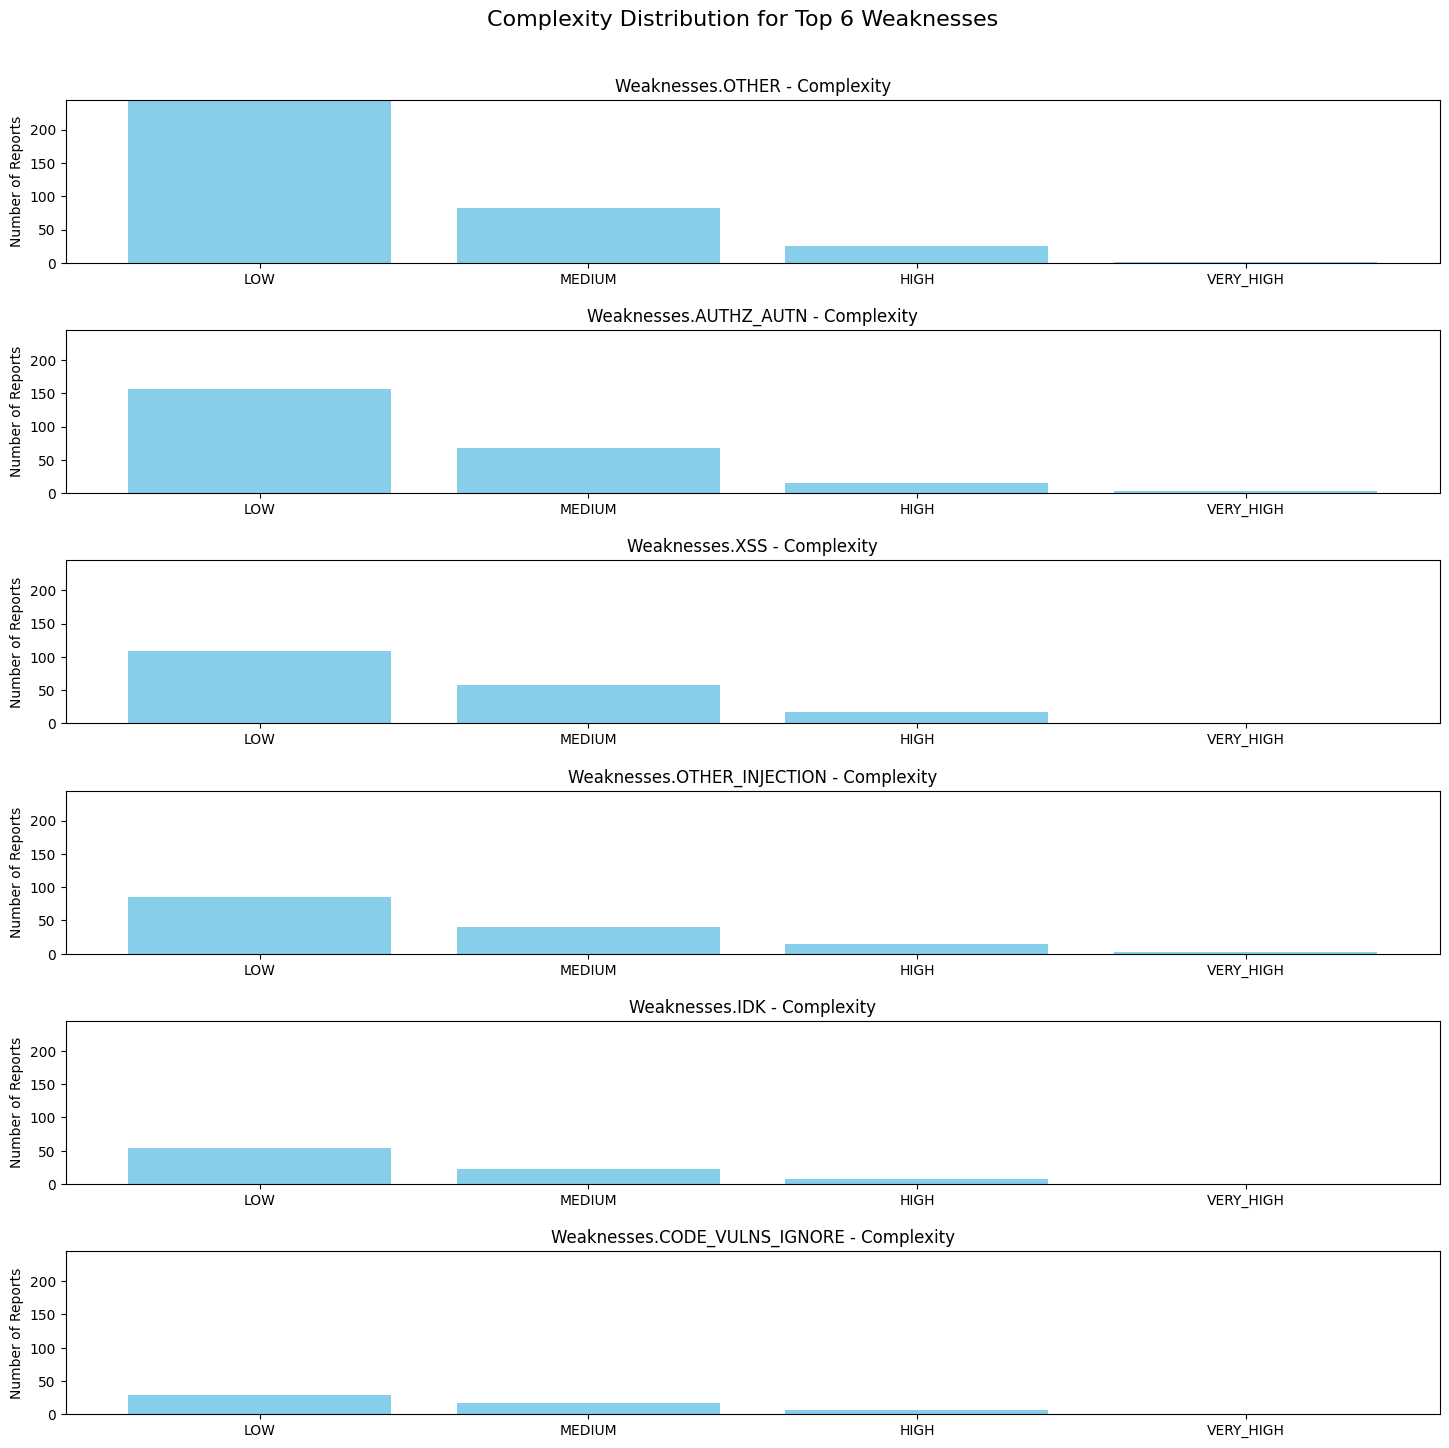

In [9]:
from pathlib import Path
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from typing import Union, List

class SeverityLevel(Enum):
    HIGH = "HIGH"
    MEDIUM = "MEDIUM"
    LOW = "LOW"

def map_severity_to_level(severity: Union[List[float], None]) -> str:
    """Map severity scores to standardized levels
    
    Args:
        severity: List of severity scores or None
    Returns:
        Severity level string
    """
    if not severity:  # Handle None or empty list
        return SeverityLevel.LOW.value
        
    # Filter out None values and convert to float
    valid_scores = [float(score) for score in severity if score is not None]
    
    if not valid_scores:  # If no valid scores after filtering
        return SeverityLevel.LOW.value
    
    # Use the highest severity score
    max_severity = max(valid_scores)
    
    if max_severity >= 7.0:
        return SeverityLevel.HIGH.value
    elif max_severity >= 4.0:
        return SeverityLevel.MEDIUM.value
    else:
        return SeverityLevel.LOW.value

def analyze_weakness_complexity_novelty(reports):
    """Analyze complexity and novelty for top 6 weaknesses
    
    Args:
        reports: List of report JSON objects
    """
    # Initialize weakness counter
    weakness_counts = Counter()
    weakness_data = {}
    
    # Process all reports
    for report in reports:
        try:
            # Skip if not HIGH severity
            severity = map_severity_to_level(report.get("severity"))
            if severity != SeverityLevel.HIGH.value:
                continue
            
            complexity = report.get("new_complexity")
            
            weaknesses = report.get("weaknesses", [])
            if not weaknesses:
                continue
            
            # Count each weakness and collect complexity data
            for weakness in weaknesses:
                weakness = convert_weakness(weakness)
                weakness_counts[weakness] += 1
                
                if weakness not in weakness_data:
                    weakness_data[weakness] = {"complexity": []}
                
                if complexity:
                    weakness_data[weakness]["complexity"].append(complexity)
                
        except (KeyError):
            continue
    
    # Get top 6 weaknesses
    top_6 = [w for w, _ in weakness_counts.most_common(6)]
    
    # Create a figure with 6 rows and 1 column
    fig, axes = plt.subplots(6, 1, figsize=(15, 15))
    fig.tight_layout(pad=3.0)
    
    # Define categories for complexity
    complexity_categories = ["LOW", "MEDIUM", "HIGH", "VERY_HIGH"]
    
    # Find the maximum count across all histograms to set a consistent y-axis
    max_count = 0
    for weakness in top_6:
        if weakness in weakness_data:
            complexity_data = weakness_data[weakness]["complexity"]
            
            complexity_counts = Counter(complexity_data)
            
            max_count = max(max_count, 
                           max([complexity_counts.get(cat, 0) for cat in complexity_categories], default=0))
    
    # Plot histograms for each weakness
    for i, weakness in enumerate(top_6):
        if weakness in weakness_data:
            # Complexity histogram
            complexity_data = weakness_data[weakness]["complexity"]
            complexity_counts = Counter(complexity_data)
            
            # Convert to arrays for plotting
            complexity_values = [complexity_counts.get(cat, 0) for cat in complexity_categories]
            
            axes[i].bar(complexity_categories, complexity_values, color="skyblue")
            axes[i].set_title(f"{weakness} - Complexity")
            axes[i].set_ylabel("Number of Reports")
            axes[i].set_ylim(0, max_count)  # Set consistent y-axis limit
    
    plt.suptitle("Complexity Distribution for Top 6 Weaknesses", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Load reports and run the analysis
reports_dir = Path("high_reports")
reports = []
for report_file in reports_dir.glob("*.json"):
    with open(report_file, "r") as f:
        try:
            report = json.load(f)
            reports.append(report)
        except json.JSONDecodeError:
            continue

analyze_weakness_complexity_novelty(filtered_reports)


Error processing high_reports\1092574.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\1618100.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\183239.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\186194.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\192321.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\217745.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\312118.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\744692.json: Expecting value: line 1 column 1 (char 0)
TOTAL BOUNTY FOR  LOW : 507580
TOTAL BOUNTY FOR  MEDIUM : 706449
TOTAL BOUNTY FOR  HIGH : 708960


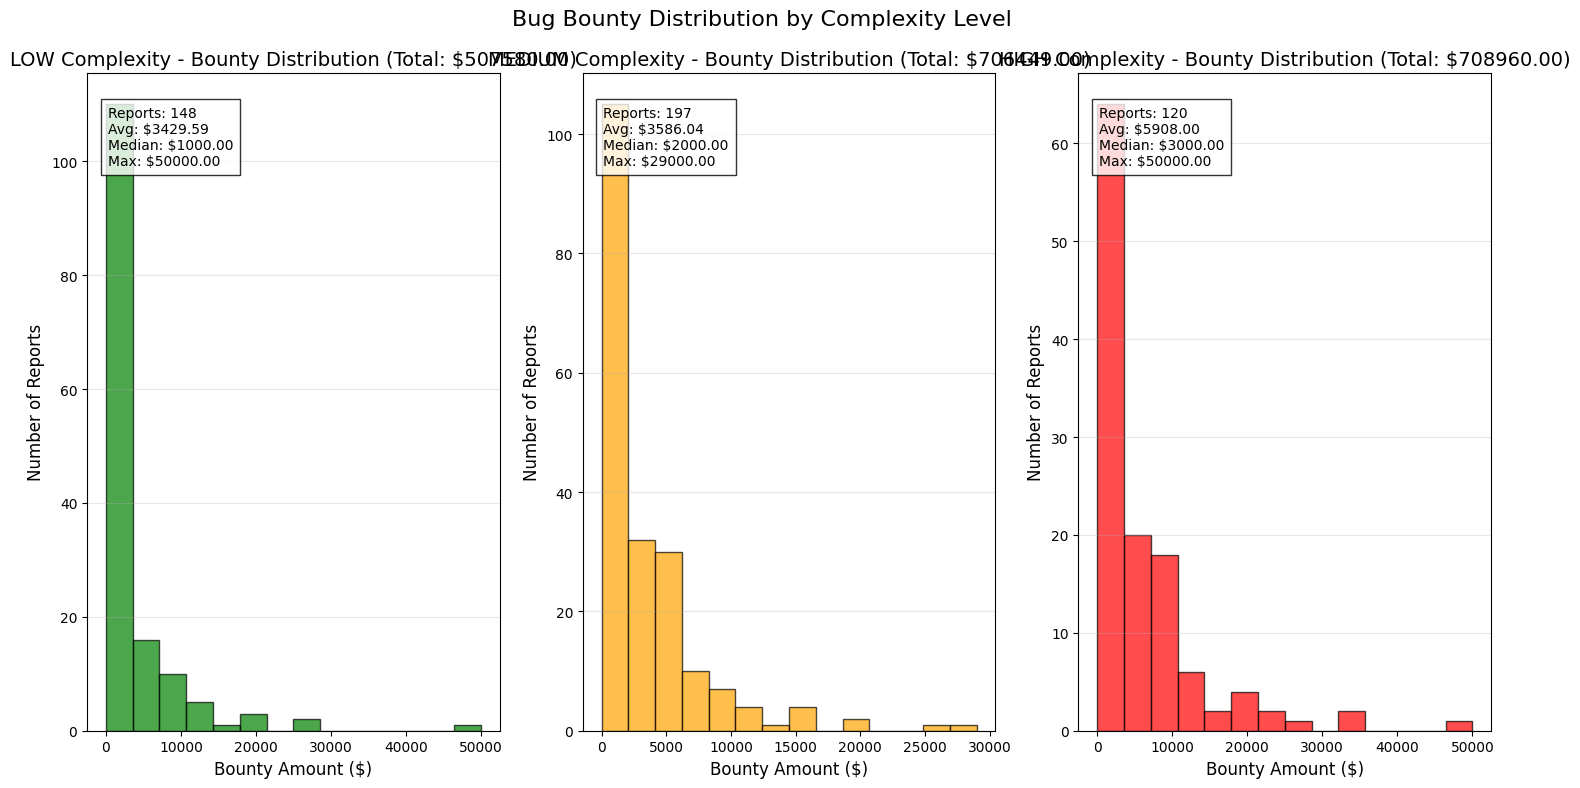

In [14]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def analyze_bounty_distribution():
    """
    Analyze and visualize the distribution of bug bounty amounts from reports
    in the scrapers/high_reports directory, separated by complexity level.
    """
    # Path to the reports directory
    reports_dir = Path("high_reports")
    
    # Dictionaries to store bounty amounts by complexity
    bounties_by_complexity = {
        "LOW": [],
        "MEDIUM": [],
        "HIGH": []  # This will include both HIGH and VERY_HIGH
    }
    
    # Iterate through all JSON files in the directory
    for file_path in reports_dir.glob("*.json"):
        try:
            with open(file_path, "r") as f:
                report = json.load(f)
                
                # Check if bounty exists and is not None
                if "bounty" in report and report["bounty"] is not None:
                    # Use new_complexity field instead of complexity
                    complexity = report.get("new_complexity", "UNKNOWN")
                    
                    # Group HIGH and VERY_HIGH into HIGH
                    if complexity == "VERY_HIGH":
                        complexity = "HIGH"
                        
                    if complexity in bounties_by_complexity:
                        bounties_by_complexity[complexity].append(report["bounty"])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Create a figure with 3 subplots (one for each complexity level)
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    
    # Colors for each complexity level
    colors = {
        "LOW": "green",
        "MEDIUM": "orange",
        "HIGH": "red",
    }
    
    # Plot histogram for each complexity level
    for i, (complexity, bounties) in enumerate(bounties_by_complexity.items()):
        # Filter out None values
        bounties = [b for b in bounties if b is not None]
        
        if bounties:
            max_bounty = max(bounties)
            min_bounty = min(bounties)
            total_bounty = sum(bounties)
            
            print("TOTAL BOUNTY FOR ", complexity, ":", total_bounty)
            # Create histogram with appropriate bins
            if min_bounty == max_bounty:
                bins = [min_bounty - 1, max_bounty + 1]  # Just two bins if all values are the same
            else:
                # Create reasonable bins based on the data
                bins = np.linspace(min_bounty, max_bounty, 15)
            
            axes[i].hist(bounties, bins=bins, color=colors[complexity], alpha=0.7, edgecolor="black")
            
            axes[i].set_title(f"{complexity} Complexity - Bounty Distribution (Total: ${total_bounty:.2f})", fontsize=14)
            axes[i].set_xlabel("Bounty Amount ($)", fontsize=12)
            axes[i].set_ylabel("Number of Reports", fontsize=12)
            axes[i].grid(axis="y", alpha=0.3)
            
            # Add some statistics as text
            avg_bounty = np.mean(bounties)
            median_bounty = np.median(bounties)
            stats_text = f"Reports: {len(bounties)}\n"
            stats_text += f"Avg: ${avg_bounty:.2f}\n"
            stats_text += f"Median: ${median_bounty:.2f}\n"
            stats_text += f"Max: ${max_bounty:.2f}"
            
            axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes, fontsize=10,
                       verticalalignment="top", bbox={"facecolor": "white", "alpha": 0.8, "pad": 5})
        else:
            axes[i].text(0.5, 0.5, "No data available", 
                       ha="center", va="center", transform=axes[i].transAxes)
    
    plt.suptitle("Bug Bounty Distribution by Complexity Level", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Run the analysis
analyze_bounty_distribution()


In [17]:
# TODO
# Recalculate the graph above with additional bounty information
# Calculate an average over each year to multiply the total bounty amount
# BONUS: account for gradual decline of bounty

In [50]:
# AUTHNZ Analysis
# TODO: include samples of these issues in the Appendix
import os
%reload_ext autoreload

total_authnz = 0
easy_detect_authz = 0
out_dir = "authnz/not_easy"

class Weaknesses(str, Enum):
    XSS = "XSS"
    AUTHZ_AUTHN = "AUTHZ/AUTN"
    OTHER_INJECTION = "OTHER_INJECTION"
    SSRF = "SSRF"
    OTHER = "OTHER"
    CODE_VULNS_IGNORE = "CODE_VULNS_IGNORE"
    IDK = "IDK"

def extract_report_id(report):
    """hackerone.com/reports/397130"""
    report_id = report["report_url"].split("/")[-1]
    return int(report_id)

for report in filtered_reports:
    weakness = convert_weakness(report["weaknesses"][0])
    if weakness == Weaknesses.AUTHZ_AUTHN:
        total_authnz += 1
        # if report.get("new_complexity", None):
        #     if report["new_complexity"] in ["HIGH", "VERY_HIGH"]:
        #         easy_detect_authz += 1

        if report.get("authnz_metadata", None):
            if not report["authnz_metadata"]["idor_detectable"] \
                and not report["authnz_metadata"]["authnz_byppass_detectable"]:
                easy_detect_authz += 1

                with open(os.path.join(out_dir, f"{extract_report_id(report)}.json"), "w") as f:
                    f.write(json.dumps(report, indent=4))

print(f"Reports with both IDOR and AuthNZ bypass detectable: {easy_detect_authz}")
print(f"Total reports: {total_authnz}")
print(f"Percentage: {(easy_detect_authz/total_authnz)*100:.1f}%")

Reports with both IDOR and AuthNZ bypass detectable: 51
Total reports: 242
Percentage: 21.1%


In [56]:
# INJECTION Analysis
# TODO: include samples of these issues in the Appendix
# INJECTION Analysis
# TODO: include samples of these issues in the Appendix
import os
out_dir = "injections/hard"

total_inject = 0
easy_detect_inject = 0

for report in filtered_reports:
    weakness = convert_weakness(report["weaknesses"][0])
    if weakness in [Weaknesses.OTHER_INJECTION, Weaknesses.XSS]:
        total_inject += 1
        if report.get("new_complexity", None):
            if report["new_complexity"] in ["HIGH", "VERY_HIGH"]:
                easy_detect_inject += 1
        # if report.get("injection_metadata", None):
        #     if not report["injection_metadata"]["is_simple_payload"]:
        #         easy_detect_inject += 1
                
                with open(os.path.join(out_dir, f"{extract_report_id(report)}.json"), "w") as f:
                    f.write(json.dumps(report, indent=4))

print(f"Reports with simple injection payload: {easy_detect_inject}")
print(f"Total reports: {total_inject}")
print(f"Percentage: {(easy_detect_inject/total_inject)*100:.1f}%")

Reports with simple injection payload: 62
Total reports: 327
Percentage: 19.0%
